<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1><h1>Pre-trained-Models with PyTorch </h1>

In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>

<h2 id="download_data">Download Data</h2>

Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:

In [10]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2020-09-22 15:17:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

100%[====================================>] 2,598,656,062 42.3MB/s   in 58s    

2020-09-22 15:18:10 (42.4 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [17]:
!unzip -q Positive_tensors.zip

In [12]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip

--2020-09-22 15:18:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

100%[====================================>] 2,111,408,108 42.5MB/s   in 48s    

2020-09-22 15:19:00 (42.0 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



In [18]:
!unzip -q Negative_tensors.zip

We will install torchvision:

In [3]:
!pip install torchvision

     |████████████████████████████████| 5.9MB 7.5MB/s eta 0:00:01
     |████████████████████████████████| 748.8MB 56kB/s s eta 0:00:01     |████████▋                       | 202.6MB 76.5MB/s eta 0:00:08     |███████████████████▉            | 463.5MB 29.7MB/s eta 0:00:10


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [4]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [5]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->

<h2 id="data_class">Dataset Class</h2>

 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.

In [15]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [19]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [20]:
def show_data(sample, shape = (224, 224)):
    plt.imshow(sample[0][0].numpy().reshape(shape), cmap='gray')
    if (sample[1].item()):
        plt.title('Com rachadura')
    else:
        plt.title('Sem rachadura')

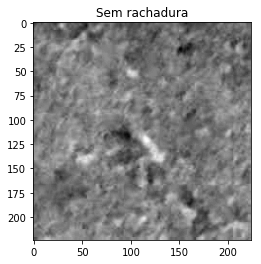

In [21]:
show_data(train_dataset[99])

<h2 id="Question_1">Question 1</h2>

<b>Prepare a pre-trained resnet18 model :</b>

<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [22]:
# Step 1: Load the pre-trained model resnet18

# Type your code here

model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dsxuser/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [23]:
# Step 2: Set the parameter cannot be trained for the pre-trained model


# Type your code here

for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [24]:
model.fc = nn.Linear(512, 2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [25]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>

In this question you will train your, model:

<b>Step 1</b>: Create a cross entropy criterion function 

In [27]:
# Step 1: Create the loss function

# Type your code here

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [28]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [29]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**

In [33]:
from datetime import datetime

n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    print('epoch: {} - {}'.format(epoch, datetime.now()))

    for i, (x, y) in enumerate(train_loader):
        if i % 10 == 0:
            print('rodada: {} - {}'.format(i, datetime.now()))
        
        model.train() 
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.data)

    correct=0
    for x_test, y_test in validation_loader:
        model.eval()
        z = model(x_test)
        _, y_hat = torch.max(z.data, 1)
        correct +=(yhat==y_test).sum().item()
   
    accuracy=correct/N_test

epoch: 0 - 2020-09-22 17:38:44.764315
rodada: 0 - 2020-09-22 17:38:44.842414
rodada: 10 - 2020-09-22 17:39:34.924451
rodada: 20 - 2020-09-22 17:40:24.855671
rodada: 30 - 2020-09-22 17:41:14.671107
rodada: 40 - 2020-09-22 17:42:04.100668
rodada: 50 - 2020-09-22 17:42:53.662781
rodada: 60 - 2020-09-22 17:43:43.870891
rodada: 70 - 2020-09-22 17:44:33.521254
rodada: 80 - 2020-09-22 17:45:23.058967
rodada: 90 - 2020-09-22 17:46:12.627048
rodada: 100 - 2020-09-22 17:47:02.045002
rodada: 110 - 2020-09-22 17:47:51.368947
rodada: 120 - 2020-09-22 17:48:42.776749
rodada: 130 - 2020-09-22 17:49:35.780947
rodada: 140 - 2020-09-22 17:50:27.954834
rodada: 150 - 2020-09-22 17:51:20.654852
rodada: 160 - 2020-09-22 17:52:13.775128
rodada: 170 - 2020-09-22 17:53:06.195617
rodada: 180 - 2020-09-22 17:53:58.013850
rodada: 190 - 2020-09-22 17:54:49.969261
rodada: 200 - 2020-09-22 17:55:42.625431
rodada: 210 - 2020-09-22 17:56:35.561494
rodada: 220 - 2020-09-22 17:57:27.597365
rodada: 230 - 2020-09-22 17:58

NameError: name 'yhat' is not defined

In [37]:
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        if i % 10 == 0:
            print('rodada: {} - {}'.format(i, datetime.now()))
        model.eval()
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct +=(yhat==y_test).sum().item()
   
    accuracy=correct/N_test

rodada: 0 - 2020-09-22 18:13:57.526869
rodada: 10 - 2020-09-22 18:14:48.663082
rodada: 20 - 2020-09-22 18:15:39.944953
rodada: 30 - 2020-09-22 18:16:31.896816
rodada: 40 - 2020-09-22 18:17:23.306335
rodada: 50 - 2020-09-22 18:18:14.106602
rodada: 60 - 2020-09-22 18:19:05.250381
rodada: 70 - 2020-09-22 18:19:56.623424
rodada: 80 - 2020-09-22 18:20:47.844126
rodada: 90 - 2020-09-22 18:21:38.495965


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>

In [38]:
accuracy

0.9937

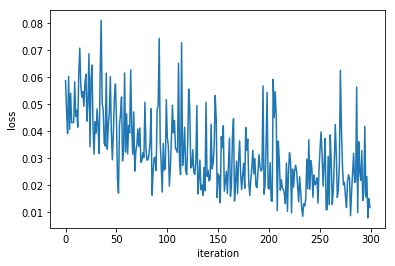

In [39]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 

<b>Identify the first four misclassified samples using the validation data:</b>

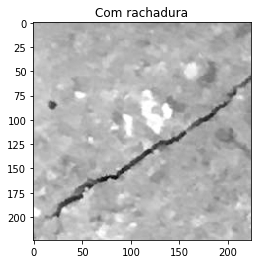

yhat: tensor([0]) at index 80


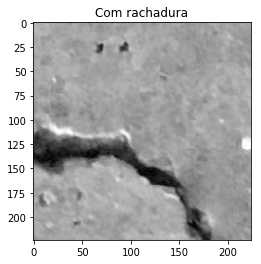

yhat: tensor([0]) at index 378


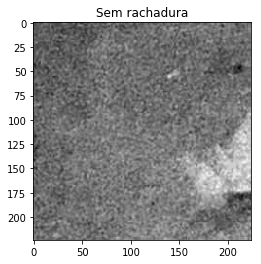

yhat: tensor([1]) at index 397


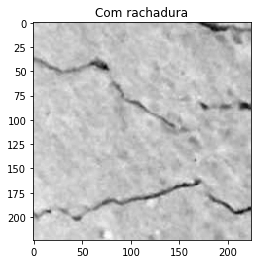

yhat: tensor([0]) at index 434


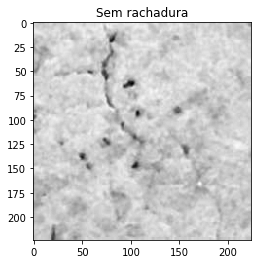

yhat: tensor([1]) at index 507


In [57]:
count = 0
index = 0;
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data([x[0],y])
        plt.show()
        print("yhat: {} at index {}".format(yhat, index))
        count += 1
    if count >= 5:
        break
    index += 1

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.